In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as Data
import numpy as np
import pandas as pd
from tqdm import tqdm
# import optuna
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import warnings
import random
import time
from torch.backends import cudnn
import torch.nn.functional as F

warnings.filterwarnings('ignore')
# plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False



In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
cudnn.benchmark = False
cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = pd.read_csv('ETTh1.csv')
data.dropna(axis=0, how='any')
data_all = data.iloc[:, 1:]


In [61]:
input_length = 96
output_length = 96
sqe_len = input_length
len_int = 7
data_x = []
data_y = []
for i in range(0, len(data_all) - input_length - output_length, 5):
    data_x.append(data_all[i: i+input_length])
    data_y.append(data_all.iloc[i+input_length: i+input_length+output_length, -1])
print(len(data_x), len(data_y))
x_train, x_test, y_train, y_test = train_test_split(np.array(data_x), np.array(data_y), test_size=0.2, random_state=1, shuffle=True)

print(len(x_train))
print(len(x_test))


3446 3446
2756
690


In [62]:
class DataSet(Data.Dataset):
    def __init__(self, data_inputs, data_targets):
        self.inputs = torch.FloatTensor(data_inputs)
        self.label = torch.FloatTensor(data_targets)
    
    def __getitem__(self, index):
        return self.inputs[index], self.label[index]

    def __len__(self):
        return len(self.inputs)

Batch_Size = 8
dataSet = DataSet(np.array(x_train), list(y_train))
train_size = int(len(x_train) * 0.7)
test_size = len(y_train) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataSet, [train_size, test_size])
TrainDataLoader = Data.DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True, drop_last=True)
TestDataLoader = Data.DataLoader(test_dataset, batch_size=Batch_Size, shuffle=True, drop_last=True)


In [63]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        chunk = x.chunk(x.size(-1), dim=2)
        out = torch.Tensor([]).to(x.device)
        for i in range(len(chunk)):
            out = torch.cat((out, chunk[i] + self.pe[:chunk[i].size(0), ...]), dim=2)
        return out
    
def transformer_generate_tgt_mask(length, device):
    mask = torch.tril(torch.ones(length, length, device=device)) == 1
    mask = (
        mask.float()
        .masked_fill(mask == 0, float('-inf'))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask

class Transformer(nn.Module):
    def __init__(self, n_encoder_inputs, n_decoder_inputs, Sequence_length, d_model=512, dropout=0.1, num_layers=8, output=96):
        super(Transformer, self).__init__()
        self.input_pos_embedding = torch.nn.Embedding(500, embedding_dim=d_model)
        self.target_pos_embedding = torch.nn.Embedding(500, embedding_dim=d_model)

        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=num_layers, dropout=dropout, dim_feedforward=4*d_model)
        decoder_layer = torch.nn.TransformerDecoderLayer(d_model=d_model, nhead=num_layers, dropout=dropout, dim_feedforward=4*d_model)

        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=4)

        self.lstm = nn.LSTM(len_int, len_int, num_layers=1, bidirectional=False)
        self.input_projection = torch.nn.Linear(n_encoder_inputs, d_model)
        self.output_projection = torch.nn.Linear(n_decoder_inputs, d_model)

        self.linear = torch.nn.Linear(d_model, 1)
        self.ziji_add_linear = torch.nn.Linear(Sequence_length, output)
        self.relu = F.relu

    def encode_in(self, src):
        src_start = self.input_projection(src).permute(1, 0, 2)
        in_sequence_len, batch_size = src_start.size(0), src_start.size(1)
        pos_encoder = (torch.arange(0, in_sequence_len, device=src.device).unsqueeze(0).repeat(batch_size, 1))
        pos_encoder = self.input_pos_embedding(pos_encoder).permute(1, 0, 2)
        src = src_start + pos_encoder
        src = self.encoder(src) + src_start
        return src

    def decode_out(self, tgt, memory):
        tgt_start = self.output_projection(tgt).permute(1, 0, 2)
        out_sequence_len, batch_size = tgt_start.size(0), tgt_start.size(1)
        pos_decoder = (torch.arange(0, out_sequence_len, device=tgt.device).unsqueeze(0).repeat(batch_size, 1))
        pos_decoder = self.target_pos_embedding(pos_decoder).permute(1, 0, 2)
        tgt = tgt_start + pos_decoder
        tgt_mask = transformer_generate_tgt_mask(out_sequence_len, tgt.device)
        out = self.decoder(tgt=tgt, memory=memory, tgt_mask=tgt_mask) + tgt_start
        out = out.permute(1, 0, 2)
        out = self.linear(out)
        return out
    
    def forward(self, src, target_in):
        lstm_out, (h_n, c_n) = self.lstm(src)
        src = self.encode_in(self.relu(lstm_out))
        out = self.decode_out(tgt=target_in, memory=src)
        # torch.Size([batch, 3, 1])
        out = out.squeeze(2)
        out = self.ziji_add_linear(out)
        return out


def test_main(model):
    val_epoch_loss = []
    val_epoch_loss_2 = []
    with torch.no_grad():
        for index, (inputs, targets) in enumerate(TestDataLoader):
            inputs = torch.tensor(inputs).to(device)
            targets = torch.tensor(targets).to(device)
            inputs = inputs.float()
            targets = targets.float()
            tgt_in = torch.rand((Batch_Size, input_length, 7)).to(device)
            outputs = model(inputs, tgt_in)
            loss = criterion(outputs.float(), targets.float())
            loss_2 = F.l1_loss(outputs.float(), targets.float())
    
            val_epoch_loss.append(loss.item())
            val_epoch_loss_2.append(loss_2.item())
    return np.mean(val_epoch_loss), np.mean(val_epoch_loss_2)


In [64]:
# 训练
model = Transformer(n_encoder_inputs=len_int, n_decoder_inputs=len_int, Sequence_length=sqe_len, output=output_length).to(device) # 3表示Sequence_length transformer输入数据 序列的长度

epochs = 100
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss().to(device)


val_loss = []
train_loss = []
val_loss_2 = []
train_loss_2 = []

best_test_loss = 10000000
for epoch in tqdm(range(epochs)):
    train_epoch_loss = []
    train_epoch_loss_2 = []
    for index, (inputs, targets) in enumerate(TrainDataLoader):
        inputs = torch.tensor(inputs).to(device)
        targets = torch.tensor(targets).to(device)
        inputs = inputs.float()
        targets = targets.float()

        tgt_in = torch.rand((Batch_Size, input_length, 7)).to(device)
        outputs = model(inputs, tgt_in)
        loss = criterion(outputs.float(), targets.float())
        loss_2 = F.l1_loss(outputs.float(), targets.float())
        print('loss:', loss)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_epoch_loss_2.append(loss_2.item())

    train_loss.append(np.mean(train_epoch_loss))
    train_loss_2.append(np.mean(train_epoch_loss_2))
    val_epoch_loss, val_epoch_loss_2 = test_main(model)
    val_loss.append(val_epoch_loss)
    val_loss_2.append(val_epoch_loss_2)
    print('epoch:', epoch, "train_epoch_loss:", np.mean(train_epoch_loss), 'val_epoch_loss:', val_epoch_loss)

    if val_epoch_loss < best_test_loss:
        best_test_loss = val_epoch_loss
        best_model = model
        print('best_test_loss ---------------------', best_test_loss)
        torch.save(best_model.state_dict(), str(output_length) + 'best_Transformer_trainModel_5.pth')
        

  0%|          | 0/100 [00:00<?, ?it/s]

loss: tensor(312.9535, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(318.3365, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(296.2828, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(244.7142, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(90.4840, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(413.0348, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(185.4366, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(359.5894, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(150.4100, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(89.8527, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(67.7391, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(144.8430, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(275.7015, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(101.2893, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(144.3405, device='cuda:0', grad_fn=<Ms

  1%|          | 1/100 [00:08<13:53,  8.42s/it]

epoch: 0 train_epoch_loss: 111.45985655566963 val_epoch_loss: 82.25110394746355
best_test_loss --------------------- 82.25110394746355
loss: tensor(68.4096, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.2246, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(70.0602, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(83.6701, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(100.4127, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(95.6598, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(52.6109, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(190.1204, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(128.9854, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(77.3485, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(74.8338, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(44.8845, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(109.1215, device='cuda:0', grad_fn=<MseLossBa

  2%|▏         | 2/100 [00:16<13:40,  8.37s/it]

epoch: 1 train_epoch_loss: 66.87977071026054 val_epoch_loss: 61.85702329468958
best_test_loss --------------------- 61.85702329468958
loss: tensor(45.0278, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(75.3322, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(40.4420, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.7108, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.0737, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(133.1396, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(66.4642, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.7615, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.6689, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.0662, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(68.6344, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(101.9604, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(66.0114, device='cuda:0', grad_fn=<MseLossBackw

  3%|▎         | 3/100 [00:25<13:31,  8.36s/it]

epoch: 2 train_epoch_loss: 50.21314166294589 val_epoch_loss: 47.96488590610837
best_test_loss --------------------- 47.96488590610837
loss: tensor(37.1204, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(64.2489, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.6167, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(70.0519, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.1093, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(85.8004, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(70.4496, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.7406, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(60.4876, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(48.3596, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(80.1609, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(49.1518, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(82.4602, device='cuda:0', grad_fn=<MseLossBackwar

  4%|▍         | 4/100 [00:33<13:21,  8.35s/it]

epoch: 3 train_epoch_loss: 43.57611705257685 val_epoch_loss: 41.89526666252358
best_test_loss --------------------- 41.89526666252358
loss: tensor(23.7131, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.0114, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.3142, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(108.7333, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(47.9762, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(64.8990, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(70.9197, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(52.1275, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.3463, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.9655, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(45.6172, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(38.2811, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(56.7537, device='cuda:0', grad_fn=<MseLossBackwa

  5%|▌         | 5/100 [00:41<13:14,  8.36s/it]

epoch: 4 train_epoch_loss: 36.73064085853545 val_epoch_loss: 36.3916384502522
best_test_loss --------------------- 36.3916384502522
loss: tensor(38.9048, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(42.3942, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.7019, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(42.7065, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(42.6241, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.0336, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.4062, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.2473, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(55.9812, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.0902, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(75.0225, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.4051, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.6590, device='cuda:0', grad_fn=<MseLossBackward0>

  6%|▌         | 6/100 [00:50<13:06,  8.37s/it]

epoch: 5 train_epoch_loss: 31.942585203162864 val_epoch_loss: 33.38991197567542
best_test_loss --------------------- 33.38991197567542
loss: tensor(40.5269, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.4520, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(40.1003, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.6864, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.6966, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.7726, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.1158, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.1868, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(57.9661, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.6052, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(35.1700, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.5565, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.8057, device='cuda:0', grad_fn=<MseLossBackwa

  7%|▋         | 7/100 [00:58<12:59,  8.38s/it]

epoch: 6 train_epoch_loss: 29.40887863705267 val_epoch_loss: 29.92138482066034
best_test_loss --------------------- 29.92138482066034
loss: tensor(19.5739, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.9014, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.3220, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.9348, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(36.3861, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.6274, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(40.3655, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.0131, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.6687, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.3020, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.6797, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.9627, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.7758, device='cuda:0', grad_fn=<MseLossBackwar

  8%|▊         | 8/100 [01:07<12:52,  8.40s/it]

epoch: 7 train_epoch_loss: 27.605273440665723 val_epoch_loss: 27.822358307329196
best_test_loss --------------------- 27.822358307329196
loss: tensor(24.1747, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.2150, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.7589, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.1949, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.5491, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.5728, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.8614, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.3953, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.3700, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(38.4541, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.2933, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.8922, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(35.4067, device='cuda:0', grad_fn=<MseLossBack

  9%|▉         | 9/100 [01:15<12:46,  8.42s/it]

epoch: 8 train_epoch_loss: 25.701465675939662 val_epoch_loss: 25.865491112459054
best_test_loss --------------------- 25.865491112459054
loss: tensor(17.2501, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.1106, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.1827, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.0687, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.9160, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.2337, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.6943, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.6282, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.5729, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.5799, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.1826, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.0926, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.7389, device='cuda:0', grad_fn=<MseLossBack

 10%|█         | 10/100 [01:23<12:36,  8.40s/it]

epoch: 9 train_epoch_loss: 26.80152724689468 val_epoch_loss: 26.897081412157966
loss: tensor(60.5125, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(57.0193, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(35.6762, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.9578, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.1026, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.9241, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.8264, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.1332, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.3394, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.6090, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.1954, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.1906, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(5.7341, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.4704, device='cuda:0', grad_fn=<Mse

 11%|█         | 11/100 [01:32<12:25,  8.38s/it]

epoch: 10 train_epoch_loss: 29.926900671725452 val_epoch_loss: 34.16842581924883
loss: tensor(15.5322, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.5861, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.2412, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(51.0584, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.6019, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.9596, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.1329, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.3349, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.8287, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.0954, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.3409, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.3872, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.7128, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(35.6569, device='cuda:0', grad_fn=<M

 12%|█▏        | 12/100 [01:40<12:20,  8.42s/it]

epoch: 11 train_epoch_loss: 26.745558182728242 val_epoch_loss: 25.70375154550793
best_test_loss --------------------- 25.70375154550793
loss: tensor(29.2967, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.2305, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.4678, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.4664, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.7181, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.7560, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.7248, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.4683, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.4169, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.7293, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.5384, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.6422, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.2875, device='cuda:0', grad_fn=<MseLossBackwa

 13%|█▎        | 13/100 [01:49<12:11,  8.41s/it]

epoch: 12 train_epoch_loss: 26.416264807040267 val_epoch_loss: 28.71617512564057
loss: tensor(24.5340, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.8559, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8986, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.2346, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.4719, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.6587, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.4216, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.0853, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.7865, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.2533, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.5666, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(69.3257, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.7921, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(47.2216, device='cuda:0', grad_fn=<

 14%|█▍        | 14/100 [01:57<12:03,  8.41s/it]

epoch: 13 train_epoch_loss: 24.60656992330591 val_epoch_loss: 27.817462884106682
loss: tensor(16.3351, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(59.8740, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(30.3761, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.5823, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.3688, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.8286, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.0685, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.1641, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(35.4872, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.3004, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.2060, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.5420, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.4210, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.5092, device='cuda:0', grad_fn=<

 15%|█▌        | 15/100 [02:06<12:00,  8.47s/it]

epoch: 14 train_epoch_loss: 23.322904491820275 val_epoch_loss: 23.5104611591228
best_test_loss --------------------- 23.5104611591228
loss: tensor(36.1994, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.7046, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.6482, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.9309, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.7631, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.6180, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(61.7086, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.0152, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.7901, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.7940, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.6101, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.9180, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.8396, device='cuda:0', grad_fn=<MseLossBackward

 16%|█▌        | 16/100 [02:14<11:53,  8.49s/it]

epoch: 15 train_epoch_loss: 22.568023481804307 val_epoch_loss: 23.0237233615616
best_test_loss --------------------- 23.0237233615616
loss: tensor(25.4478, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.4279, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.1592, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.2361, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.2888, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(6.9947, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.5288, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.9904, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.9639, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.3902, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(36.5820, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.4983, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.4542, device='cuda:0', grad_fn=<MseLossBackward

 17%|█▋        | 17/100 [02:23<11:42,  8.46s/it]

epoch: 16 train_epoch_loss: 22.413569919301267 val_epoch_loss: 24.13038915337868
loss: tensor(20.9223, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.0424, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(60.7827, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.3350, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(40.9930, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(44.2504, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(40.1731, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.7768, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(42.3334, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.6239, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.7192, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(6.7382, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.5578, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.2287, device='cuda:0', grad_fn=<Ms

 18%|█▊        | 18/100 [02:31<11:35,  8.49s/it]

epoch: 17 train_epoch_loss: 22.273448186296644 val_epoch_loss: 21.443672633865503
best_test_loss --------------------- 21.443672633865503
loss: tensor(14.3607, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.3815, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.3016, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(46.5254, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.2641, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.4102, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.0948, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.5898, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.9678, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.7563, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.9888, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.9734, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.0583, device='cuda:0', grad_fn=<MseLossBac

 19%|█▉        | 19/100 [02:40<11:25,  8.46s/it]

epoch: 18 train_epoch_loss: 21.01939520895234 val_epoch_loss: 22.239308445199022
loss: tensor(10.6697, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.1038, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.0017, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.7820, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.5736, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.5317, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.9918, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(47.6645, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.4935, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.5027, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.6455, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.6768, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.9045, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.6045, device='cuda:0', grad_fn=<

 20%|██        | 20/100 [02:48<11:19,  8.49s/it]

epoch: 19 train_epoch_loss: 20.504175631337144 val_epoch_loss: 20.920893595056626
best_test_loss --------------------- 20.920893595056626
loss: tensor(21.9363, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.4087, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.9343, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.8521, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.5853, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.7735, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.1730, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.3307, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.0898, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(36.2334, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.3618, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.2708, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.6562, device='cuda:0', grad_fn=<MseLossBac

 21%|██        | 21/100 [02:57<11:10,  8.49s/it]

epoch: 20 train_epoch_loss: 20.45674760707681 val_epoch_loss: 23.003158939694895
loss: tensor(18.5039, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.0706, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.1819, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.7699, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.8080, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.7897, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.0348, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.9998, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.0428, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.7486, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(43.8426, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(30.2053, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.7467, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.2250, device='cuda:0', grad_fn=<

 22%|██▏       | 22/100 [03:05<11:02,  8.49s/it]

epoch: 21 train_epoch_loss: 20.11363381864619 val_epoch_loss: 20.981644144336
loss: tensor(27.7886, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.5506, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.0713, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.5021, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.9660, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.3283, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.3678, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.0319, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.7188, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(42.7566, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.2718, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.7025, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(6.7478, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.1660, device='cuda:0', grad_fn=<MseLos

 23%|██▎       | 23/100 [03:14<10:53,  8.49s/it]

epoch: 22 train_epoch_loss: 20.99923904901718 val_epoch_loss: 22.015254409567824
loss: tensor(14.7829, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.2383, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.1787, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(35.1694, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.6561, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.9921, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.9293, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.9193, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.0485, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.6117, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.3433, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.9961, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.6755, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.7248, device='cuda:0', grad_fn=<M

 24%|██▍       | 24/100 [03:22<10:48,  8.54s/it]

epoch: 23 train_epoch_loss: 21.24294275267985 val_epoch_loss: 20.4281083681051
best_test_loss --------------------- 20.4281083681051
loss: tensor(14.1159, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.0350, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.1994, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.1613, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.4983, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.7765, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.1635, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.5558, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.1509, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.3737, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.8658, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.3328, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.0767, device='cuda:0', grad_fn=<MseLossBackward

 25%|██▌       | 25/100 [03:31<10:39,  8.52s/it]

epoch: 24 train_epoch_loss: 23.994165804376244 val_epoch_loss: 24.982654441907567
loss: tensor(24.5611, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.9219, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.6319, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.2716, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.9593, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.9546, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.9457, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.7734, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.3820, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.5339, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.9140, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(36.1183, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.2675, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.1898, device='cuda:0', grad_fn=

 26%|██▌       | 26/100 [03:39<10:29,  8.51s/it]

epoch: 25 train_epoch_loss: 25.800354098877968 val_epoch_loss: 27.72896455561073
loss: tensor(22.2312, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.3274, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.5359, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.7961, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.0903, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.1154, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.2058, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.9446, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(42.0823, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.3708, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.2091, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(50.0742, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.0371, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(60.0836, device='cuda:0', grad_fn=<

 27%|██▋       | 27/100 [03:48<10:22,  8.53s/it]

epoch: 26 train_epoch_loss: 28.03351037828754 val_epoch_loss: 32.858671151318596
loss: tensor(20.0553, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.1479, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.9855, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(49.9609, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(44.8610, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.4153, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.7727, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(49.6675, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.5917, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.5575, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.9102, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.2434, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(53.9252, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.0458, device='cuda:0', grad_fn=<

 28%|██▊       | 28/100 [03:56<10:14,  8.54s/it]

epoch: 27 train_epoch_loss: 35.039982008241516 val_epoch_loss: 38.843951725265356
loss: tensor(47.7610, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(36.0433, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(58.1116, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.0751, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(39.6022, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.9879, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.0122, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.6782, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.0374, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.3557, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.8523, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(71.6214, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(51.1253, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(38.2633, device='cuda:0', grad_fn=

 29%|██▉       | 29/100 [04:05<10:06,  8.54s/it]

epoch: 28 train_epoch_loss: 38.536815912397074 val_epoch_loss: 42.15881445801374
loss: tensor(45.9033, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.4370, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(43.3740, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.1886, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(42.2572, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.4824, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(56.4934, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.4775, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(54.2636, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(40.6380, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(40.8993, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.2609, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.1496, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(51.1364, device='cuda:0', grad_fn=<

 30%|███       | 30/100 [04:13<09:57,  8.54s/it]

epoch: 29 train_epoch_loss: 41.02217431286064 val_epoch_loss: 42.28157575848033
loss: tensor(40.7496, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(49.5753, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.4103, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(51.3455, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.8375, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.8005, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.4678, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(36.3971, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(62.5424, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.1824, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.7644, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.1053, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(51.1581, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(49.3290, device='cuda:0', grad_fn=<M

 31%|███       | 31/100 [04:22<09:49,  8.55s/it]

epoch: 30 train_epoch_loss: 38.540878161355174 val_epoch_loss: 37.31107228473552
loss: tensor(30.9754, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(38.6776, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.9597, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(50.0738, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.8211, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(44.0502, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(38.1604, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.2585, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.3949, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(46.6042, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.7621, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.3682, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.5165, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(35.1921, device='cuda:0', grad_fn=<

 32%|███▏      | 32/100 [04:30<09:40,  8.54s/it]

epoch: 31 train_epoch_loss: 57.174480406575185 val_epoch_loss: 71.20001348476966
loss: tensor(43.5307, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(114.6016, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(76.9571, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(77.5646, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(99.9529, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(92.7690, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.2610, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(57.6567, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.2426, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(66.2409, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(52.9077, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.2074, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(51.0389, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.6141, device='cuda:0', grad_fn=

 33%|███▎      | 33/100 [04:39<09:32,  8.54s/it]

epoch: 32 train_epoch_loss: 62.31436027431884 val_epoch_loss: 61.20081286754423
loss: tensor(55.9762, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(47.5414, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.4017, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(71.2014, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(107.1862, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(84.8130, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(63.7769, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.5418, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.1306, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(63.9653, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(44.5924, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(74.3922, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(87.4609, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(44.4406, device='cuda:0', grad_fn=<

 34%|███▍      | 34/100 [04:48<09:23,  8.55s/it]

epoch: 33 train_epoch_loss: 54.14413706197778 val_epoch_loss: 54.0379412660321
loss: tensor(32.6791, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(64.8396, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.8938, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.3859, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(46.2479, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(86.4751, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(45.0409, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(85.1711, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(42.9839, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.9884, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(54.8778, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(143.2414, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(30.8550, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(75.5580, device='cuda:0', grad_fn=<M

 35%|███▌      | 35/100 [04:56<09:15,  8.54s/it]

epoch: 34 train_epoch_loss: 49.19310114294662 val_epoch_loss: 48.38109992314311
loss: tensor(43.8565, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(42.7998, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(60.9225, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(65.6313, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.7310, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.5215, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(71.9641, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.0398, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.8326, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.8829, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(57.3594, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.7368, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.4057, device='cuda:0', grad_fn=<M

 36%|███▌      | 36/100 [05:05<09:06,  8.54s/it]

epoch: 35 train_epoch_loss: 43.93974282434867 val_epoch_loss: 43.036139682658664
loss: tensor(31.0740, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.8904, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.9686, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.1557, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(49.0793, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(51.8599, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.9486, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.2739, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(66.8730, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(50.6264, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(59.5762, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(63.3787, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.8943, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(43.0177, device='cuda:0', grad_fn=<

 37%|███▋      | 37/100 [05:13<08:58,  8.54s/it]

epoch: 36 train_epoch_loss: 39.24955402073524 val_epoch_loss: 39.0539998174871
loss: tensor(28.2520, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.2124, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.6026, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(44.3522, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(50.9500, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.7800, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.5529, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.5607, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(39.6849, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(54.3268, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(75.6198, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.2863, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.0277, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.8477, device='cuda:0', grad_fn=<Ms

 38%|███▊      | 38/100 [05:22<08:50,  8.55s/it]

epoch: 37 train_epoch_loss: 35.59900239097627 val_epoch_loss: 36.05466825985214
loss: tensor(35.2015, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.3256, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8814, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.5532, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.4639, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.5034, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(35.2935, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.8989, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(38.1964, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.1228, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(44.6034, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.9744, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.3563, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.2096, device='cuda:0', grad_fn=<M

 39%|███▉      | 39/100 [05:30<08:40,  8.54s/it]

epoch: 38 train_epoch_loss: 32.589975895228726 val_epoch_loss: 33.82627995500287
loss: tensor(32.8578, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.5322, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(38.7482, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.6458, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.4879, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(30.2044, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(52.8089, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.7710, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.1917, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.9133, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(40.0502, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(35.7755, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.5115, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.6841, device='cuda:0', grad_fn=<

 40%|████      | 40/100 [05:39<08:31,  8.52s/it]

epoch: 39 train_epoch_loss: 31.46368809854341 val_epoch_loss: 31.149059740085047
loss: tensor(38.2611, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.4357, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.1904, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(36.8635, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.0678, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(49.2140, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(39.6401, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.9129, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.1524, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.9682, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.3534, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(38.2982, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.5613, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(36.3230, device='cuda:0', grad_fn=<

 41%|████      | 41/100 [05:47<08:21,  8.51s/it]

epoch: 40 train_epoch_loss: 29.09040795322276 val_epoch_loss: 30.234733664873733
loss: tensor(15.1755, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.2130, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.4020, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(39.0746, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.4381, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.1984, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.1388, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.3758, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.5363, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.7048, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.8358, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.0533, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(46.1805, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.7905, device='cuda:0', grad_fn=<

 42%|████▏     | 42/100 [05:56<08:13,  8.50s/it]

epoch: 41 train_epoch_loss: 27.68824819113704 val_epoch_loss: 29.28984227226776
loss: tensor(45.7597, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.2713, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.6572, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.0155, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(39.1907, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.4277, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.2602, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.5120, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.3497, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.2164, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.4039, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.8115, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.8377, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.2213, device='cuda:0', grad_fn=<M

 43%|████▎     | 43/100 [06:04<08:04,  8.51s/it]

epoch: 42 train_epoch_loss: 26.693943083038963 val_epoch_loss: 27.96436311666248
loss: tensor(23.8861, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.1399, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.1923, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.1010, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.9127, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.1362, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.0296, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(45.9365, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.2523, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.5769, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.9386, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.9499, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.2803, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.4749, device='cuda:0', grad_fn=<

 44%|████▍     | 44/100 [06:13<07:56,  8.51s/it]

epoch: 43 train_epoch_loss: 25.516494418575554 val_epoch_loss: 26.3063589577536
loss: tensor(16.0502, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.3214, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.1773, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.7276, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.6533, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.2040, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(55.2414, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.1264, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.5843, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.8227, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.4479, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.9026, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.1543, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.3323, device='cuda:0', grad_fn=<M

 45%|████▌     | 45/100 [06:21<07:48,  8.51s/it]

epoch: 44 train_epoch_loss: 24.328957126348346 val_epoch_loss: 25.444678704715468
loss: tensor(22.3073, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.5916, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.8595, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.6155, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.9630, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.6061, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.8040, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.9973, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.1458, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.5118, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.3900, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.7719, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.4120, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(30.3065, device='cuda:0', grad_fn=

 46%|████▌     | 46/100 [06:30<07:39,  8.51s/it]

epoch: 45 train_epoch_loss: 23.68934846221164 val_epoch_loss: 24.210444089278433
loss: tensor(18.6765, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.5503, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.1391, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.7060, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.1995, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.2325, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.2097, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.1905, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.8673, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.5503, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.6172, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.7805, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.8814, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.1868, device='cuda:0', grad_fn=<

 47%|████▋     | 47/100 [06:38<07:30,  8.51s/it]

epoch: 46 train_epoch_loss: 22.757187896744345 val_epoch_loss: 23.207551914511374
loss: tensor(19.5037, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.3849, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.8832, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.7159, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.1417, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.0067, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.3207, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.6802, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.8087, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.1929, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.9803, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.6535, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.7085, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.8530, device='cuda:0', grad_fn=

 48%|████▊     | 48/100 [06:47<07:22,  8.51s/it]

epoch: 47 train_epoch_loss: 21.825181917530866 val_epoch_loss: 23.329966244188327
loss: tensor(23.9419, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.2449, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.9250, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.6195, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.2600, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.9117, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.8347, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(39.3441, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.4209, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.6948, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.5287, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.8354, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.4584, device='cuda:0', grad_fn=

 49%|████▉     | 49/100 [06:55<07:14,  8.52s/it]

epoch: 48 train_epoch_loss: 21.89187731287786 val_epoch_loss: 22.833960135006212
loss: tensor(12.5209, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.4978, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.0498, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.1242, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.5694, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.0597, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.8835, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.4800, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.1976, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.1852, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.8017, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.8268, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8845, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.9752, device='cuda:0', grad_fn=<M

 50%|█████     | 50/100 [07:04<07:05,  8.52s/it]

epoch: 49 train_epoch_loss: 21.49897867416445 val_epoch_loss: 22.59974649114516
loss: tensor(25.6262, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.4189, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.2784, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8318, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.5661, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.9329, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.8914, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.0214, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8404, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.0911, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.8989, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.3624, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.4210, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.2662, device='cuda:0', grad_fn=<M

 51%|█████     | 51/100 [07:12<06:57,  8.52s/it]

epoch: 50 train_epoch_loss: 20.91469312010959 val_epoch_loss: 21.147961491519965
loss: tensor(11.0505, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.3709, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.0521, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.8095, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.7401, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.2808, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.0784, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.7706, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.2400, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.5533, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.8776, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(35.7726, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.4698, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.6748, device='cuda:0', grad_fn=<

 52%|█████▏    | 52/100 [07:21<06:48,  8.51s/it]

epoch: 51 train_epoch_loss: 20.999163910561084 val_epoch_loss: 21.08825807664001
loss: tensor(25.6681, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.7404, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.1369, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.9433, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.0424, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.6217, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.4265, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.0470, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.1573, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.1787, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.5992, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.2350, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(5.5004, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.6612, device='cuda:0', grad_fn=<Ms

 53%|█████▎    | 53/100 [07:29<06:39,  8.51s/it]

epoch: 52 train_epoch_loss: 20.507285517775667 val_epoch_loss: 21.383054612909707
loss: tensor(18.8065, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.4188, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.0780, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.3837, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.7943, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.7631, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.4038, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.3566, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.3524, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.8443, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(44.3719, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.9080, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.4373, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(7.8921, device='cuda:0', grad_fn=<

 54%|█████▍    | 54/100 [07:38<06:31,  8.51s/it]

epoch: 53 train_epoch_loss: 20.25974399123449 val_epoch_loss: 21.216532984983573
loss: tensor(20.4959, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(30.6779, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.2404, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.3022, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.2542, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(30.1532, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.0341, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.4264, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.9936, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.7229, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.0295, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.6582, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.7280, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.1288, device='cuda:0', grad_fn=<M

 55%|█████▌    | 55/100 [07:46<06:22,  8.51s/it]

epoch: 54 train_epoch_loss: 20.254420062813026 val_epoch_loss: 21.818106433720263
loss: tensor(23.8011, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.5144, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.1271, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.9481, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.9177, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8365, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.0203, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.8500, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.8986, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.1553, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.3474, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.1088, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.6581, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.2808, device='cuda:0', grad_fn=

 56%|█████▌    | 56/100 [07:55<06:16,  8.56s/it]

epoch: 55 train_epoch_loss: 20.363465404114784 val_epoch_loss: 20.42588536716202
best_test_loss --------------------- 20.42588536716202
loss: tensor(13.9348, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.1830, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.3056, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.0408, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.3206, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.9794, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.2537, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.3476, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.5361, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.9094, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.4033, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.1618, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.6955, device='cuda:0', grad_fn=<MseLossBackw

 57%|█████▋    | 57/100 [08:04<06:07,  8.54s/it]

epoch: 56 train_epoch_loss: 19.815422857450745 val_epoch_loss: 20.618025913979242
loss: tensor(15.6519, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.3173, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.0104, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.0143, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.4265, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.5367, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.4703, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.3943, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.6090, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.0568, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.6266, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.1830, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.4253, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.8450, device='cuda:0', grad_fn=<

 58%|█████▊    | 58/100 [08:12<05:58,  8.53s/it]

epoch: 57 train_epoch_loss: 19.335173088485273 val_epoch_loss: 21.30651925374003
loss: tensor(25.2547, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.6301, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.6406, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.9912, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.4668, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.1540, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.3008, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.1594, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.7855, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.6745, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.7671, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.2217, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.0791, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(43.6676, device='cuda:0', grad_fn=<

 59%|█████▉    | 59/100 [08:21<05:51,  8.57s/it]

epoch: 58 train_epoch_loss: 19.866359558342896 val_epoch_loss: 20.04896616241307
best_test_loss --------------------- 20.04896616241307
loss: tensor(40.3850, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.2049, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.3608, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.6866, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.3651, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.7726, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.2935, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.7699, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.7959, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.8222, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(29.1706, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.5437, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.4882, device='cuda:0', grad_fn=<MseLossBackw

 60%|██████    | 60/100 [08:29<05:42,  8.56s/it]

epoch: 59 train_epoch_loss: 19.97186222313845 val_epoch_loss: 20.463383313521597
loss: tensor(15.6476, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.2820, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.7926, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(40.6925, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.0102, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.7399, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.5695, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.4788, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.2231, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(36.0836, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.3053, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.9237, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.6118, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(40.8933, device='cuda:0', grad_fn=<

 61%|██████    | 61/100 [08:38<05:32,  8.53s/it]

epoch: 60 train_epoch_loss: 19.790307846306764 val_epoch_loss: 20.4580455891137
loss: tensor(22.9870, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.8620, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.5036, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.1626, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.6612, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.0702, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.2346, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.9054, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.2901, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.3164, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.0855, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.0622, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.4203, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.3769, device='cuda:0', grad_fn=<M

 62%|██████▏   | 62/100 [08:46<05:23,  8.51s/it]

epoch: 61 train_epoch_loss: 19.34817976971385 val_epoch_loss: 20.174389913244156
loss: tensor(8.3356, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.2203, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.8237, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.7621, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.8917, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.9543, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.6133, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.2388, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.6773, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.0315, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.6465, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(35.8456, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.7527, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.9929, device='cuda:0', grad_fn=<Mse

 63%|██████▎   | 63/100 [08:55<05:16,  8.56s/it]

epoch: 62 train_epoch_loss: 19.066808142602692 val_epoch_loss: 19.72814222909872
best_test_loss --------------------- 19.72814222909872
loss: tensor(17.0062, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.8295, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.9398, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(30.0274, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.6001, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.5443, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.5083, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.9299, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.9038, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.7193, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.7305, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.9729, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.5558, device='cuda:0', grad_fn=<MseLossBackw

 64%|██████▍   | 64/100 [09:04<05:09,  8.60s/it]

epoch: 63 train_epoch_loss: 19.1590835365517 val_epoch_loss: 19.631309125029926
best_test_loss --------------------- 19.631309125029926
loss: tensor(27.2046, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.7699, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.2498, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.1625, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.4592, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.2331, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.6005, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.1215, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.4988, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.5427, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.2367, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.1514, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.5665, device='cuda:0', grad_fn=<MseLossBackw

 65%|██████▌   | 65/100 [09:12<05:00,  8.59s/it]

epoch: 64 train_epoch_loss: 19.153335644496426 val_epoch_loss: 19.06084131500096
best_test_loss --------------------- 19.06084131500096
loss: tensor(13.0601, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.4800, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.4772, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.9885, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.9697, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.2217, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.1785, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.7604, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8148, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.6097, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.8799, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.3072, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.2131, device='cuda:0', grad_fn=<MseLossBackw

 66%|██████▌   | 66/100 [09:21<04:51,  8.56s/it]

epoch: 65 train_epoch_loss: 18.77707978402925 val_epoch_loss: 19.984884465782386
loss: tensor(13.0653, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.0794, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.3763, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.4200, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.8544, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.1076, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.5992, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.8407, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.3371, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.9326, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.6689, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.2652, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.9533, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.9419, device='cuda:0', grad_fn=<

 67%|██████▋   | 67/100 [09:29<04:41,  8.53s/it]

epoch: 66 train_epoch_loss: 18.671369966134986 val_epoch_loss: 20.086039635741596
loss: tensor(13.7615, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.2339, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(33.0494, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.9919, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(6.9189, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.7920, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.9179, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.3818, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.0697, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.2787, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.2731, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.8580, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.6628, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.5188, device='cuda:0', grad_fn=<

 68%|██████▊   | 68/100 [09:38<04:32,  8.51s/it]

epoch: 67 train_epoch_loss: 18.598142887052163 val_epoch_loss: 20.26772075023466
loss: tensor(11.0428, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.4429, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.8507, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.1533, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.4738, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.4733, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.6649, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.1087, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.0035, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.2303, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.3020, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.8081, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.9331, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.1402, device='cuda:0', grad_fn=<

 69%|██████▉   | 69/100 [09:46<04:24,  8.54s/it]

epoch: 68 train_epoch_loss: 18.487038454079528 val_epoch_loss: 18.901243043177335
best_test_loss --------------------- 18.901243043177335
loss: tensor(23.0347, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.1250, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(30.9998, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.5030, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.7532, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.9718, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.1275, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.6790, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.3989, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.7125, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.4058, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.0887, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.2614, device='cuda:0', grad_fn=<MseLossBack

 70%|███████   | 70/100 [09:55<04:17,  8.57s/it]

epoch: 69 train_epoch_loss: 18.210699146713953 val_epoch_loss: 18.852226030479358
best_test_loss --------------------- 18.852226030479358
loss: tensor(17.3134, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.1191, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.9294, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.2587, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.7860, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(37.3477, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.9033, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.9679, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.3553, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.0269, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.3061, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.5317, device='cuda:0', grad_fn=<MseLossBack

 71%|███████   | 71/100 [10:03<04:07,  8.54s/it]

epoch: 70 train_epoch_loss: 18.090456721199004 val_epoch_loss: 18.949592812547404
loss: tensor(24.3134, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.2060, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.4687, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.2267, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.6929, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.5612, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.0468, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.7111, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.3958, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.8658, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(7.5282, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.3956, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.7787, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.0482, device='cuda:0', grad_fn=<M

 72%|███████▏  | 72/100 [10:12<03:58,  8.52s/it]

epoch: 71 train_epoch_loss: 18.196936358060086 val_epoch_loss: 19.085861381975192
loss: tensor(18.2644, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.3710, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.7316, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(30.7236, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(32.0863, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.5104, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.6369, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(7.9791, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.0614, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.4886, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.3770, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.0361, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.1644, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.3491, device='cuda:0', grad_fn=<

 73%|███████▎  | 73/100 [10:20<03:51,  8.57s/it]

epoch: 72 train_epoch_loss: 17.883591970467467 val_epoch_loss: 18.63135224407159
best_test_loss --------------------- 18.63135224407159
loss: tensor(12.6574, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8097, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.2483, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.0203, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8331, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.0636, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.1840, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.1838, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.8277, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.2775, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.1817, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.7275, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.5114, device='cuda:0', grad_fn=<MseLossBackwa

 74%|███████▍  | 74/100 [10:29<03:43,  8.58s/it]

epoch: 73 train_epoch_loss: 17.561975174425054 val_epoch_loss: 17.845053982966153
best_test_loss --------------------- 17.845053982966153
loss: tensor(18.8380, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.7051, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.8919, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8032, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.1550, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.3958, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.4474, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.7588, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.5355, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.7717, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.5832, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.6232, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.1479, device='cuda:0', grad_fn=<MseLossBac

 75%|███████▌  | 75/100 [10:38<03:33,  8.55s/it]

epoch: 74 train_epoch_loss: 17.658233794928588 val_epoch_loss: 18.531944293420292
loss: tensor(11.6502, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.5868, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.6077, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.3650, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.8481, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.3996, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.8541, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.5352, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.1591, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.6306, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.6806, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.9416, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.2567, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.4737, device='cuda:0', grad_fn=

 76%|███████▌  | 76/100 [10:46<03:24,  8.53s/it]

epoch: 75 train_epoch_loss: 17.518391486520095 val_epoch_loss: 18.837145680362738
loss: tensor(24.2377, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.3026, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.4486, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.7191, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.5718, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.0465, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.9681, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.5297, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.3441, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.7006, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.7548, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(7.7127, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.0747, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.0294, device='cuda:0', grad_fn=<M

 77%|███████▋  | 77/100 [10:54<03:15,  8.51s/it]

epoch: 76 train_epoch_loss: 17.582563501176004 val_epoch_loss: 18.492955235601627
loss: tensor(7.8988, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.0594, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.7461, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.6983, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.0886, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.3640, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.0370, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.6771, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.3072, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.3168, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.4354, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.1586, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.0848, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.6031, device='cuda:0', grad_fn=<

 78%|███████▊  | 78/100 [11:03<03:06,  8.49s/it]

epoch: 77 train_epoch_loss: 17.727945988603647 val_epoch_loss: 18.181731599048504
loss: tensor(9.1858, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.5634, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.7540, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.7595, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.6113, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.9622, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.0530, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.9646, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.8597, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.8975, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.8028, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.2101, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.6048, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.8668, device='cuda:0', grad_fn=<Ms

 79%|███████▉  | 79/100 [11:11<02:58,  8.49s/it]

epoch: 78 train_epoch_loss: 17.503562772917054 val_epoch_loss: 18.325123467491668
loss: tensor(12.2115, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.0140, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.5576, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.6454, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.7222, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.2038, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.1298, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.2447, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.8328, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.2584, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.3972, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.6359, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.7466, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.5948, device='cuda:0', grad_fn=<

 80%|████████  | 80/100 [11:20<02:50,  8.52s/it]

epoch: 79 train_epoch_loss: 17.098383028972197 val_epoch_loss: 17.23190528443716
best_test_loss --------------------- 17.23190528443716
loss: tensor(8.3202, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.8153, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.6875, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.5235, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.0380, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.0500, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.7409, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.3124, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.0759, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.0316, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.7900, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.4338, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(7.8579, device='cuda:0', grad_fn=<MseLossBackwar

 81%|████████  | 81/100 [11:28<02:41,  8.50s/it]

epoch: 80 train_epoch_loss: 17.369505943599084 val_epoch_loss: 18.16348948062045
loss: tensor(25.9119, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.0902, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.7202, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.3254, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.3651, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.9339, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.7581, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.9535, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.0433, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.5821, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.1256, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.8032, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.4074, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.5051, device='cuda:0', grad_fn=<

 82%|████████▏ | 82/100 [11:37<02:32,  8.47s/it]

epoch: 81 train_epoch_loss: 17.33172198449922 val_epoch_loss: 18.598130175210898
loss: tensor(21.9744, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.2262, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.6356, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.6609, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.6557, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.3736, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.1945, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.3942, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.9203, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.2896, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.2063, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.2339, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.4527, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.1334, device='cuda:0', grad_fn=<

 83%|████████▎ | 83/100 [11:45<02:23,  8.46s/it]

epoch: 82 train_epoch_loss: 16.88940554733593 val_epoch_loss: 17.56294481499681
loss: tensor(17.2893, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8663, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.7622, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(47.0120, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.2965, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.6244, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.2017, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.2613, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.9091, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.1710, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.0772, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.0125, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.7655, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.7899, device='cuda:0', grad_fn=<M

 84%|████████▍ | 84/100 [11:54<02:15,  8.45s/it]

epoch: 83 train_epoch_loss: 17.013532549513823 val_epoch_loss: 18.426904581125502
loss: tensor(19.6994, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.4444, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.2427, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.2491, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.4311, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.8443, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.4341, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.8645, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.2968, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.4668, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.2845, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.0751, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.1635, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.2350, device='cuda:0', grad_fn=

 85%|████████▌ | 85/100 [12:02<02:06,  8.45s/it]

epoch: 84 train_epoch_loss: 17.03526029151505 val_epoch_loss: 18.20067149690054
loss: tensor(20.5666, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.4588, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.2178, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.4340, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.5744, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.3448, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.9218, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.7905, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.5780, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.6088, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.2126, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.6459, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.0964, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.9837, device='cuda:0', grad_fn=<Ms

 86%|████████▌ | 86/100 [12:11<01:58,  8.45s/it]

epoch: 85 train_epoch_loss: 17.20273909034571 val_epoch_loss: 17.62806012329546
loss: tensor(16.2772, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.5761, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.5210, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.8148, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.0055, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.6436, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.4964, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.5370, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.6424, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.8293, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.9212, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.3912, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.5724, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.6832, device='cuda:0', grad_fn=<MseL

 87%|████████▋ | 87/100 [12:19<01:49,  8.45s/it]

epoch: 86 train_epoch_loss: 17.263207690844396 val_epoch_loss: 18.78072184960819
loss: tensor(15.0640, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.0025, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.3697, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.5859, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.6589, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(39.2592, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.8092, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.5980, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.4395, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.2658, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.8361, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.7067, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.0274, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.9887, device='cuda:0', grad_fn=<M

 88%|████████▊ | 88/100 [12:27<01:41,  8.46s/it]

epoch: 87 train_epoch_loss: 17.802003872345097 val_epoch_loss: 18.526306374559123
loss: tensor(25.1635, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.1945, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.6511, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.0543, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.4222, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.6749, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.4303, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.9171, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.6103, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.8051, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.4942, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.9455, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.2487, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.1738, device='cuda:0', grad_fn=<M

 89%|████████▉ | 89/100 [12:36<01:33,  8.46s/it]

epoch: 88 train_epoch_loss: 17.427574832409743 val_epoch_loss: 17.45081924697728
loss: tensor(11.4679, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.7706, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(34.8359, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.5090, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.1386, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.3782, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.6790, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(41.8282, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.3721, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.9816, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.5776, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.2350, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(23.7838, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.7279, device='cuda:0', grad_fn=<M

 90%|█████████ | 90/100 [12:44<01:24,  8.46s/it]

epoch: 89 train_epoch_loss: 17.54980857540463 val_epoch_loss: 17.9042350759784
loss: tensor(14.7264, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.8500, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.4069, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.2044, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.8057, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.8214, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.7763, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.8976, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.5667, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.8990, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(28.6880, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.9348, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.8201, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.9245, device='cuda:0', grad_fn=<Ms

 91%|█████████ | 91/100 [12:53<01:16,  8.47s/it]

epoch: 90 train_epoch_loss: 16.346793451744492 val_epoch_loss: 17.81887443320265
loss: tensor(10.9370, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.6227, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.9885, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.0342, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.9813, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.4125, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.3313, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.3213, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.8795, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.3012, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.3186, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.2473, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.6179, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.0300, device='cuda:0', grad_fn=<

 92%|█████████▏| 92/100 [13:01<01:07,  8.47s/it]

epoch: 91 train_epoch_loss: 17.23267128259809 val_epoch_loss: 17.293394625765607
loss: tensor(9.2840, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.7965, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.1435, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.1858, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.8822, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.6318, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.7598, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(7.5733, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.4656, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.8914, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.6806, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.0328, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.8631, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.2606, device='cuda:0', grad_fn=<Mse

 93%|█████████▎| 93/100 [13:10<00:59,  8.47s/it]

epoch: 92 train_epoch_loss: 16.257961866766586 val_epoch_loss: 17.349757648208765
loss: tensor(19.2526, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.6021, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.3122, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(20.6023, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.6780, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.6589, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8239, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.9906, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.8469, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(24.2871, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.1149, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.8510, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(27.8128, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.2301, device='cuda:0', grad_fn=<Ms

 94%|█████████▍| 94/100 [13:18<00:51,  8.52s/it]

epoch: 93 train_epoch_loss: 16.79391100792469 val_epoch_loss: 16.901175892468796
best_test_loss --------------------- 16.901175892468796
loss: tensor(12.8628, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.0848, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.0193, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.9941, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.5228, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.5741, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.3058, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.5410, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.6103, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.5729, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.1864, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.8200, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.8548, device='cuda:0', grad_fn=<MseLossBackw

 95%|█████████▌| 95/100 [13:27<00:42,  8.51s/it]

epoch: 94 train_epoch_loss: 16.260416669964297 val_epoch_loss: 17.37578288791249
loss: tensor(12.4863, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.8069, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.3526, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.3762, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.4955, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.5953, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.7944, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(21.6170, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.8579, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.2602, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.1997, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.6482, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.5939, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(25.2864, device='cuda:0', grad_fn=<M

 96%|█████████▌| 96/100 [13:35<00:34,  8.50s/it]

epoch: 95 train_epoch_loss: 16.291693717117624 val_epoch_loss: 16.94271993174136
loss: tensor(16.4967, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.0298, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.9584, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.3212, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.7241, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.7936, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.3359, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.7656, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(7.1454, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(19.5760, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.1010, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.5821, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(8.7909, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.5595, device='cuda:0', grad_fn=<Ms

 97%|█████████▋| 97/100 [13:44<00:25,  8.50s/it]

epoch: 96 train_epoch_loss: 16.275229537140778 val_epoch_loss: 17.216931690290135
loss: tensor(23.1563, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.8317, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.9643, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(12.9578, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.4130, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.6460, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.4581, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.2487, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.8839, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(31.5253, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.3534, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.8068, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.2678, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.7866, device='cuda:0', grad_fn=<

 98%|█████████▊| 98/100 [13:53<00:17,  8.56s/it]

epoch: 97 train_epoch_loss: 16.457814311585487 val_epoch_loss: 16.833627626733872
best_test_loss --------------------- 16.833627626733872
loss: tensor(14.9609, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.2325, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(7.3688, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(7.3925, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.4318, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(18.0698, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.7347, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.5155, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.0840, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.5003, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.8040, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(13.1059, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.0240, device='cuda:0', grad_fn=<MseLossBackw

 99%|█████████▉| 99/100 [14:01<00:08,  8.54s/it]

epoch: 98 train_epoch_loss: 16.532516956329346 val_epoch_loss: 17.455038982687643
loss: tensor(17.0423, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.4388, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.3722, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(15.2240, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(26.0619, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(10.7612, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(22.1509, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(11.2072, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.1810, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.7267, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(9.6929, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(17.9591, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(14.7389, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(16.9390, device='cuda:0', grad_fn=<

100%|██████████| 100/100 [14:10<00:00,  8.50s/it]

epoch: 99 train_epoch_loss: 16.45950991879855 val_epoch_loss: 18.08685220329507


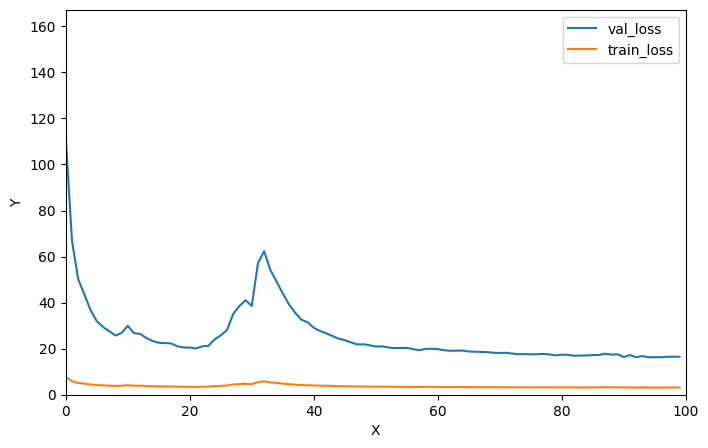

In [67]:
# 画图
# loss图
fig = plt.figure(facecolor='white', figsize=(8, 5))
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(xmax=len(val_loss), xmin=0)
plt.ylim(ymax=max(max(train_loss), max(val_loss)) * 1.5, ymin=0)

x1 = [i for i in range(0, len(train_loss), 1)]
y1 = train_loss
x2 = [i for i in range(0, len(train_loss), 1)]
y2 = train_loss_2

area = np.pi * 4 ** 1
# 画散点图
plt.plot(x1, y1, label='val_loss')
plt.plot(x2, y2, label='train_loss')
plt.legend()
plt.savefig('./Pic/loss1.png', format='png')
plt.show()


In [60]:
# 模型预测
def prediction_main(seed):
    model.load_state_dict(torch.load(str(output_length) + 'best_Transformer_trainModel_5.pth'))
    model.eval()
    random.seed(seed)
    torch.manual_seed(seed)

    with torch.no_grad():
        inputs, targets = random.choice(list(TestDataLoader))
        inputs = torch.tensor(inputs).to(device)
        targets = torch.tensor(targets).to(device)
        inputs = inputs.float()
        targets = targets.float()
        tgt_in = torch.rand((Batch_Size, input_length, 7)).to(device)
        outputs = model(inputs, tgt_in)
        k = random.randint(0, 7)
        y_pred = np.array(outputs.cpu().numpy()[k])
        y_true = np.array(targets.cpu().numpy()[k])
        prediction_plot(y_pred, y_true)
        mae_val = np.mean(np.abs(y_pred - y_true))
        mse_val = np.mean((y_pred - y_true) ** 2)
        return mae_val, mse_val

        
def prediction_plot(y_pred, y_true):
    len_ = [i for i in range(len(y_pred[0:1000]))]
    plt.xlabel('label', fontsize=8)
    plt.ylabel('value', fontsize=8)
    plt.plot(len_, y_true[0:1000], color='r', label='y_true')
    plt.plot(len_, y_pred[0:1000], color='b', label='y_pred')
    plt.title('prediction')
    plt.legend()
    plt.savefig('./Pic/prediction' + str(output_length) + str(seed) + 'pic.png', format='png')
    plt.close()


output_length = 336
mae_list = []
mse_list = []
for seed in [2, 23, 98, 1024, 1000]:
    mae_val, mse_val = prediction_main(seed)
    mae_list.append(mae_val)
    mse_list.append(mse_val)


In [58]:

df = pd.DataFrame({'mae': mae_list, 'mse': mse_list})
print(df)
print(np.std(np.array(mae_list)))
print(np.std(np.array(mse_list)))


    
    
    



        mae        mse
0  2.082543   6.471348
1  2.607666  11.916430
2  3.097926  15.652379
3  6.917708  57.264214
4  3.172996  14.645912
1.7161624
18.316534
